In [1]:
import minirats.utils.py.readwrite.ramses_info as ri
from minirats.utils.py import cellutils as cu
import minirats.utils.py.plots as mplots
from ratatouille import readNsave as ras
from ratatouille import plotutils as put
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
plt.rcParams['figure.facecolor']='w'
plt.rcParams['font.size'] = 14

In [3]:
genpath = '/mnt/lyoccf/scratch/mrey/outputs/2_G8/'
folder='1_base/' 
RamsesDir = genpath+folder
RamsesDir = '/home/max/PhD/Simus/Offline_temp/'
timestep  = 17

In [4]:
info = ri.rd_info(timestep,RamsesDir)

g2Msun = 1. / 1.989e33
pc2cm = 3.086e18
cm2kpc = 1.e-3 / pc2cm

size_box_kpc = info['boxlen']

#### Some params

In [5]:
cen = size_box_kpc/2
center = [cen,cen,cen]
rad_kpc = 20
rad_kpc = 1
# Have to replace info['boxlen'] by size_simu in kpc 
# which holds true if info['boxlen'] is 1

# Gas: $\Sigma_{gas}$

#### Read cells

In [6]:
%time
# Cells data
_, cells,cell_pos,cell_l = ras.extract_cells(RamsesDir,timestep, \
                                center_box=[0.5,0.5,0.5], rad_box=2, saveinfile=False)
# Cells params
cell_dx, rho, _, _, _, _, _, _, _, _, _, _, _, _ = cells # cm and g/cm^3

#rho_Msun = rho *  g2Msun * pc2cm**3   # Msun/pc^3
res_min = size_box_kpc/2**cell_l.max()
print('The resolution of the simulation is ', res_min)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.29 µs
Reading but not saving cells
Done counting cells
read_cells done.
Done extracting cells
read_params_from_cells done.
The resolution of the simulation is  0.03662109375


In [7]:
sig_gas, nb_makemap_bins \
    = put.compute_sig_gas_HR(rho, center, rad_kpc, cell_pos, cell_l, info)

The resolution right after make_map is ~ 0.036364 kpc
Error of 0.71 % induced by using it: using 55 pixels instead of ~ 54.61 


# 3D gas

In [8]:
xmin_kpc, xmax_kpc, ymin_kpc, ymax_kpc, zmin_kpc, zmax_kpc\
    = ras.compute_edges(center, rad_kpc)

In [9]:
from minirats.utils.py.maps import cube_maker as cm

#prop = [0.25, 0.25, 1]
prop = [1, 1, 1]
for i in prop:
    if i>1 or 1<0:
        raise ValueError('prop value of {} not correct'.format(i))
prodprop = prop[0] * prop[1] * prop[2]
range_box = [0.5-prop[0]/2,0.5+prop[0]/2,0.5-prop[1]/2,0.5+prop[1]/2,0.5-prop[2]/2,0.5+prop[2]/2]  # gotta change xmin and all accordingly
print(range_box)


range_box=[1,1,1]

Make "normal" cube

In [11]:
cm.gen_cube(snaps=[17],var='nH',crop=range_box,rt=False,zoom=False
            ,halo_number=None,halo_rRvir=None, RunDir=RamsesDir,levelmax=7)

the snaps are  [17]
$MINIRATS/utils/f90/standalone/amr2cube -inp output_00017 -typ nH -out /home/max/PhD/maxutils/dev/cubes/nH_0.0_1.0_0.0_1.0_0.0_1.0_7_00017.dat -xmi 0.0 -xma 1.0 -ymi 0.0 -yma 1.0 -zmi 0.0 -zma 1.0 -lma 7


Read cube and try to reshape it as best as possible

---

Dafuq is recl ?  

---

In [12]:
f = open('cubes/nH_0.0_1.0_0.0_1.0_0.0_1.0_7_00017.dat', 'rb')
recl = np.fromfile(f, dtype='int32', count=1)
#f.seek(4)
field = np.fromfile(f, dtype='float32')

print('Record length=',recl)
print(field)
#print(np.shape(rho), np.shape(field))

Record length= [8388608]
[-6.0312357e+00 -6.0312357e+00 -6.0319023e+00 ... -6.0091209e+00
 -6.0091209e+00  1.1754944e-38]


In [13]:
std_pix = (len(field) / prodprop)**(1/3)
print(std_pix)

128.00002034504882


# Or don't reshape it, just load it as it is and just cut it before plotting !
More expensive but meh..

Reshaping the 1D array read

In [14]:
niushape = (int(std_pix*prop[2]),int(std_pix*prop[1]),int(std_pix*prop[0]))
delta_fuckup = abs(len(field) - niushape[0]*niushape[1]*niushape[2])
a=np.reshape(field[:-delta_fuckup],niushape)
#a=np.reshape(field[:],(-1,-1,-1))
print('The shape of the new array is {} and the difference in number of pixels is {}'\
      .format(np.shape(a),delta_fuckup))

# Have to test this method of reshaping

The shape of the new array is (128, 128, 128) and the difference in number of pixels is 1


In [15]:
#a=np.reshape(field[:],(-1,-1,-1))
print('The shape of the new array is {} and the difference in number of pixels is {}'\
      .format(np.shape(a),delta_fuckup))

The shape of the new array is (128, 128, 128) and the difference in number of pixels is 1


Just an image check

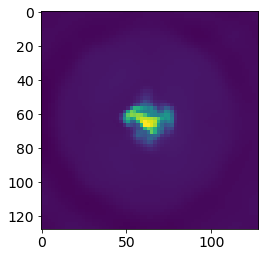

In [16]:
plt.imshow(a[3,:,:])

Adapt limits to size reduction

In [17]:
def prop_minmax(center, radius, prop):
    """
    Returns the location of the cells and the edges of the box.
    """

    # Edges of maps
    xmin,xmax = center[0]-prop[0]*radius,center[0]+prop[0]*radius
    ymin,ymax = center[1]-prop[1]*radius,center[1]+prop[1]*radius
    zmin,zmax = center[2]-prop[2]*radius,center[2]+prop[2]*radius

    return xmin, xmax, ymin, ymax, zmin, zmax

In [18]:
xmin_kpc2, xmax_kpc2, ymin_kpc2, ymax_kpc2, zmin_kpc2, zmax_kpc2 \
    = prop_minmax(center, rad_kpc, prop)
extent2 = xmin_kpc2, xmax_kpc2, ymin_kpc2, ymax_kpc2, zmin_kpc2, zmax_kpc2

### Paraview version

In [19]:
from pyevtk.hl import gridToVTK
x = np.linspace(xmin_kpc2,xmax_kpc2,np.shape(a)[0])
y = np.linspace(ymin_kpc2,ymax_kpc2,np.shape(a)[1])
z = np.linspace(zmin_kpc2,zmax_kpc2,np.shape(a)[2])
xx,yy,zz = np.meshgrid(x,y,z,indexing='ij')

#pointData for centered value otherwise cellData
gridToVTK("nh",xx,yy,zz,pointData={"nh":a})

'/home/max/PhD/maxutils/dev/nh.vts'

### Mayavi version

In [20]:
from mayavi import mlab
%gui qt

mlab.contour3d(a,contours=100, transparent=True, opacity=0.1)

In [25]:
def the_usefull_one(a):
    mlab.contour3d(a,contours=100, transparent=True, opacity=0.1)
import mayavi

def test_mayav():
    s = mlab.test_plot3d()  

def shinyslice(a):
    pts = mlab.barchart(a[0])
def cubeOFpoints(a):
    pts = mlab.points3d(a, mask_points=50, opacity=0.5, scale_mode='none', scale_factor=0.5)
    mlab.pipeline.threshold(pts, low=-1)
def quicksnap(a):
    """Can see slice and slide it through the cube ! Usefull to see quickly"""
    mlab.volume_slice(a, plane_orientation='x_axes')
def contours100(a):
    mlab.contour3d(a,contours=100)
def contours500(a):
    mlab.contour3d(a,contours=500, transparent=True)
def mightbeusefulforoutflows(a):
    print('https://docs.enthought.com/mayavi/mayavi/auto/mlab_helper_functions.html#mayavi.mlab.flow')

a_nan = a.copy()
a_nan[a_nan < -5.5 ] = np.nan #
pts = mlab.points3d(a_nan, opacity=0.5, scale_mode='none', scale_factor=0.5)
pts.module_manager.scalar_lut_manager.lut.nan_color = 0,0,0,0 # r, g, b, alpha
mlab.colorbar()

In [26]:
quicksnap(a)

In [22]:
contours100(a)

In [23]:
kiwi

NameError: name 'kiwi' is not defined

# 3D stars
Have to weight with star_map

In [ ]:
star_mass,star_x,star_y,star_z,star_id,star_age,star_vx,star_vy,star_vz,\
    star_mets, star_minit = ras.extract_stars(RamsesDir,timestep, saveinfile=False)

g2Msun = 1. / 1.989e33
star_mass_Msun = star_mass*g2Msun

In [ ]:
cen = info['boxlen']/2
center = [cen,cen,cen]
rad_stars = 3

In [ ]:
# mlab.points3d?
cm2kpc = 1. / (3.086e18 * 1.e3)

### Plot stars

In [ ]:
from mayavi import mlab
from scipy import stats

x = star_x*cm2kpc
y = star_y*cm2kpc
z = star_z*cm2kpc

In [ ]:
%time

xyz = np.vstack([x,y,z])  
kde = stats.gaussian_kde(xyz)  
density = kde(xyz)           # have to include star_mass

In [ ]:
# Plot scatter with mayavi
from mayavi import mlab

mlab.figure(bgcolor=(1, 1, 1), size=(512, 512))
pts = mlab.points3d(x, y, z, density, scale_mode='none', mode='point') #star_mass
                    #, scale_factor=0.01, colormap='gnuplot')
# '2dcross' or '2ddiamond' or '2dvertex' or 'axes' or 'cone' or 'point' or 'sphere'
#mlab.draw()
#mlab.view(40, 85)

mlab.show()

### Ugly method

In [ ]:
def plot_3D():
    """
    That's ugly af.
    """
    %matplotlib qt
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(star_x, star_y, star_z, c=density, marker='.', alpha=0.01)

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    plt.show()

In [ ]:
plot_3D()

In [ ]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt,numpy as np
plt.clf()
fig = plt.figure(1)
ax = fig.gca(projection='3d')
X, Y, Z = x,y,z
ax.plot_surface(X, Y, Z, rstride=8, cstride=8, alpha=0.3)
cset = ax.contourf(X, Y, Z, zdir='z', offset=-100,
        levels=np.linspace(-100,100,1200),cmap=plt.cm.jet)
cset = ax.contourf(X, Y, Z, zdir='x', offset=-40, cmap=plt.cm.jet)
cset = ax.contourf(X, Y, Z, zdir='y', offset=40, cmap=plt.cm.jet)
ax.set_xlabel('X')
ax.set_xlim(-40, 40)
ax.set_ylabel('Y')
ax.set_ylim(-40, 40)
ax.set_zlabel('Z')
ax.set_zlim(-100, 100)    
plt.show()

### Weight of an array

In [ ]:
import numpy as np
ki = np.ones((1024,1024,1024))
print ('My array weights {} GB'.format(ki.nbytes*1e-9))